In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
from memflow.transfer_flow.transfer_flow import TransferFlow
from memflow.transfer_flow.transfer_flow_paper import TransferFlow_Paper
from utils import alter_variables
from utils import alter_variables_tensor
import math

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak


from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi

torch.set_num_threads(10)

# Start with checking the Transformer

# For testing: The model must be always on 'eval' mode
# For testing: Never save the gradients (`.detech().cpu()`)

In [3]:
batchSize = 128

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paper_v7/Transfer_Flow_transfer_flow_2nd_2nd_DiagNormal_NoTransf4_NoBins10_DNN:2_128/'

path_to_conf = model_dir + '/config_transfer_flow_2nd_2nd.yaml'
path_to_model = model_dir + '/model_transfer_flow_2nd_2nd.pt'

with open(path_to_conf) as f:
        config = OmegaConf.load(path_to_conf)
        
#path_data = config.input_dataset_test
path_data = config.input_dataset_validation
print(path_data)

/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet


In [4]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 15650586624
used     : 455540736


In [5]:
transfer_flow = TransferFlow_Paper(no_recoVars=config.input_shape.no_recoVars,
                no_partonVars=config.input_shape.no_partonVars,

                transformer_input_features=config.transformerConditioning.input_features,
                transformer_nhead=config.transformerConditioning.nhead,
                transformer_num_encoder_layers=config.transformerConditioning.no_encoder_layers,
                transformer_num_decoder_layers=config.transformerConditioning.no_decoder_layers,
                transformer_dim_feedforward=config.transformerConditioning.dim_feedforward,
                transformer_activation=nn.GELU(),
                 
                flow_nfeatures=config.transferFlow.nfeatures,
                flow_ntransforms=config.transferFlow.ntransforms,
                flow_hiddenMLP_NoLayers=config.transferFlow.hiddenMLP_NoLayers,
                flow_hiddenMLP_LayerDim=config.transferFlow.hiddenMLP_LayerDim,
                flow_bins=config.transferFlow.bins,
                flow_autoregressive=config.transferFlow.autoregressive,
                flow_base=config.transferFlow.base,
                flow_base_first_arg=config.transferFlow.base_first_arg,
                flow_base_second_arg=config.transferFlow.base_second_arg,
                flow_bound=config.transferFlow.bound,
                randPerm=config.transferFlow.randPerm,
                no_max_objects=config.transferFlow.no_max_objects,
                 
                device=device,
                eps=1e-4)

state_dict = torch.load(path_to_model, map_location=device)
transfer_flow.load_state_dict(state_dict['model_state_dict'])

if device == torch.device('cuda'):
    transfer_flow = transfer_flow.cuda()

In [6]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 15449260032
used     : 656867328


In [7]:
test_data = DatasetCombined(path_data, dev=device, datasets=["partons_lab", "reco_lab"], dtype=torch.float64,
                    reco_list_lab=['recoParticles',
                                   'scaledLogRecoParticles', 'mask_lepton', 
                                        'mask_jets','mask_met',
                                        'mask_boost', 'data_boost'],
                    parton_list_lab=['data_higgs_t_tbar_ISR',
                                     "logScaled_data_higgs_t_tbar_ISR"])


>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (cuda) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load recoParticles
Load scaledLogRecoParticles
Reco: Move tensors to device (cuda) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [8]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 14608302080
used     : 1497825280


In [9]:
testLoader = DataLoader(
        test_data,
        batch_size=batchSize,
        #shuffle=True,
        shuffle=False,
    )

In [10]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 14608302080
used     : 1497825280


In [11]:
No_ev = 100
perm = torch.randperm(len(test_data))
list_ev = perm[:No_ev]
#print(list_ev.tolist())
oldVersion = False

log_mean_parton = test_data.partons_lab.mean_log_data_higgs_t_tbar_ISR
log_std_parton = test_data.partons_lab.std_log_data_higgs_t_tbar_ISR
log_mean_reco = test_data.reco_lab.meanRecoParticles
log_std_reco = test_data.reco_lab.stdRecoParticles
    
if device == torch.device('cuda'):
    log_mean_parton = log_mean_parton.cuda()
    log_std_parton = log_std_parton.cuda()
    log_mean_reco = log_mean_reco.cuda()
    log_std_reco = log_std_reco.cuda()

if oldVersion:

    scaledLogReco = test_data.reco_lab.scaledLogRecoParticles[list_ev,:,:7]
    scaledLogParton = test_data.partons_lab.logScaled_data_higgs_t_tbar_ISR[list_ev]
    maskJets = test_data.reco_lab.mask_jets[list_ev]
    maskLepton = test_data.reco_lab.mask_lepton[list_ev]
    maskMET = test_data.reco_lab.mask_met[list_ev]

    boostReco = test_data.reco_lab.data_boost[list_ev]
    maskBoost = test_data.reco_lab.mask_boost[list_ev]

    maskedReco = torch.cat((maskJets, maskLepton, maskMET), dim=1)

    recoParticles = test_data.reco_lab.recoParticles[list_ev]
    data_partons = test_data.partons_lab.data_higgs_t_tbar_ISR[list_ev]

    if device == torch.device('cuda'):
        scaledLogReco = scaledLogReco.cuda()
        scaledLogParton = scaledLogParton.cuda()
        boostReco = boostReco.cuda()
        maskBoost = maskBoost.cuda()
        maskedReco = maskedReco.cuda()
        recoParticles = recoParticles.cuda()
        data_partons = data_partons.cuda()

# I. modify jets

## let's scan pt: (-10%, ..., +10%): 20 values
## let's scan eta: (-0.5, -0.45, ..., 0.45, 0.5): 20 values

## let's modify the values of random no of jets: from 1 to 7
## let's modify the values of random jets: from 1 to 7


In [12]:
No_batches = 5
print(len(testLoader))

1401


In [19]:
def hist_visible(axis, data, change, peaks_to_clip=1, bins=None, annot_kw=None,
                 range_x=(-2.5,2.5), fontsize=10):
    
    def _annotate(peaks_info, annot_kw):
        def _process_annot_kw(annot_kw):
            defaults = dict(weight='bold', fontsize=5, color='r',
                            xy=(.85, .85), xycoords='axes fraction')
            if not annot_kw:
                annot_kw = defaults.copy()
            else:
                annot_kw = annot_kw.copy()  # ensure external dict unaffected
                # if `defaults` key not in `annot_kw`, add it & its value
                for k, v in defaults.items():
                    if k not in annot_kw:
                        annot_kw[k] = v
            return annot_kw

        def _make_annotation(peaks_info):
            txt = ''
            for entry in peaks_info:
                txt += "({:.2f}, {})\n".format(entry[0], int(entry[1]))
            return txt.rstrip('\n')

        annot_kw = _process_annot_kw(annot_kw)
        txt = _make_annotation(peaks_info)
        axis.annotate(txt, **annot_kw)

    if bins == None:
        bins = range_x[1] - range_x[0]
        
    N, bins, _ = axis.hist(np.asarray(data).ravel(), bins=bins, range=range_x)

    Ns = np.sort(N)
    lower_max = Ns[-(peaks_to_clip + 1)]

    peaks_info = []
    for peak_idx in range(1, peaks_to_clip + 2):
        patch_idx = np.where(N == Ns[-peak_idx])[0][0]
        peaks_info.append([bins[patch_idx], N[patch_idx]])
        
    axis.set_ylim([0, int(lower_max + 2)])
    axis.set_xlim([range_x[0], range_x[1]])
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_title(f'change: {change}', fontsize=fontsize)

    if annot_kw is not None:
        _annotate(peaks_info, annot_kw)

In [20]:
def plot_per_change(diff_logprob, diff_change, modify_particles, particles_change='jets',
                    title_var='% pt', no_rows=4, range_x=(-2.5,2.5), peaks_to_clip=1):
    
    no_columns = math.ceil(len(diff_change)/no_rows)
    fig, axis = plt.subplots(no_rows, no_columns, figsize=(10, 10))
    
    fig.suptitle(f'{title_var} change for {particles_change}: {modify_particles} ', fontsize=20)
    fig.supxlabel('target - wrong (logprob)')
        
    for idx, change in enumerate(diff_change):
        row = math.floor(idx/no_columns)
        column = idx%no_columns
        #print(f'idx = {idx}; change = {change}; row = {row}; column = {column}')
        
        no_bins = int(range_x[1] - range_x[0])
        hist_visible(axis[row, column], diff_logprob[idx, :].flatten(), change,
                     peaks_to_clip=peaks_to_clip, bins=no_bins, range_x=range_x, annot_kw={})
        
        #axis[row, column].set_title(f'change: {change}', fontsize=10)
        #axis[row, column].set_xlim([-135, 135])
        #axis[row, column].set_ylim(0, 15)
        
        
    fig.tight_layout()

In [14]:
no_jets = torch.randint(1, 7, (1,))
print(no_jets)

perm = torch.randperm(7)
modify_jets = perm[:no_jets]
modify_jets, indices = torch.sort(modify_jets)
print(modify_jets.tolist())

tensor([6])
[0, 1, 2, 3, 5, 6]


In [15]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16106127360
free     : 14608302080
used     : 1497825280


In [16]:
target_events_logprob = torch.zeros((No_batches, batchSize), device=torch.device('cpu'))

iterator = iter(testLoader)
for idx in range(No_batches):
    transfer_flow.eval()
    data_batch = next(iterator)
    
    (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
    recoParticles, scaledLogRecoParticles, mask_lepton, 
    mask_jets, mask_met, mask_boost, boostReco) = data_batch
    
    maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)
    
    scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
    
    target_avg_flow_prob_pt, target_flow_prob_pt_batch, target_flow_prob_pt, \
    target_avg_flow_prob_eta, target_flow_prob_eta_batch, target_flow_prob_eta, \
    target_avg_flow_prob_phi, target_flow_prob_phi_batch, target_flow_prob_phi = transfer_flow(scaledLogRecoParticles,
                                                                                logScaled_data_higgs_t_tbar_ISR,
                                                                                boostReco,
                                                                                maskedReco,
                                                                                mask_boost)
    
    target_batch_flow_pr = target_flow_prob_pt_batch + target_flow_prob_eta_batch + target_flow_prob_phi_batch
    target_events_logprob[idx] = target_batch_flow_pr.detach().cpu()

/home/user/micromamba/lib/python3.9/site-packages/zuko/transforms.py:425: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  return torch.searchsorted(seq, value[..., None]).squeeze(dim=-1)


## 1st: modify pt of jets (percent)

In [17]:
percentage_change = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10]
diff_logprob_jets_pt = torch.zeros((len(percentage_change), No_batches, batchSize))

transfer_flow.eval()
for index, percent in enumerate(percentage_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
    
        difference_pt = percent/100*recoParticles[:,modify_jets,0]
        
        wrong_logScaled_reco = alter_variables_tensor(difference=difference_pt,
                                                object_no=modify_jets,
                                                variable_altered=[0],
                                                target_var=scaledLogRecoParticles, 
                                                log_mean=log_mean_reco, 
                                                log_std=log_std_reco,
                                                mask_target=maskedReco,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        wrong_avg_flow_prob_pt, wrong_flow_prob_pt_batch, wrong_flow_prob_pt, \
        wrong_avg_flow_prob_eta, wrong_flow_prob_eta_batch, wrong_flow_prob_eta, \
        wrong_avg_flow_prob_phi, wrong_flow_prob_phi_batch, wrong_flow_prob_phi = transfer_flow(wrong_logScaled_reco,
                                                                    logScaled_data_higgs_t_tbar_ISR,
                                                                    boostReco,
                                                                    maskedReco,
                                                                    mask_boost)
        
        wrong_batch_flow_pr = wrong_flow_prob_pt_batch + wrong_flow_prob_eta_batch + wrong_flow_prob_phi_batch

        diff_logprob_jets_pt[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

5.5


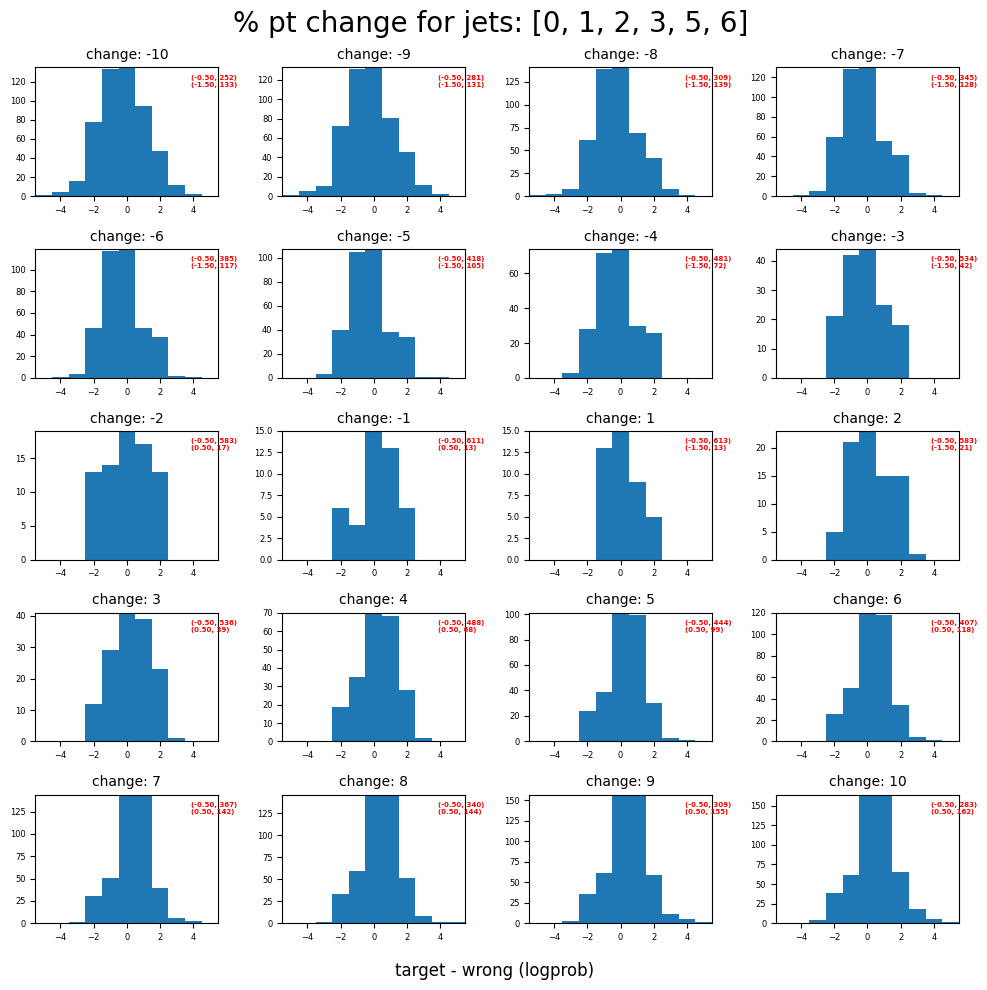

In [21]:
maxim = int(torch.max(torch.abs(diff_logprob_jets_pt).flatten()).item()) + 0.5
print(maxim)

plot_per_change(diff_logprob_jets_pt.numpy(), percentage_change, modify_jets.tolist(), title_var='% pt',
               range_x=(-1*maxim,maxim), peaks_to_clip=1, no_rows=5)

# 2nd: modify eta of jets

In [22]:
eta_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
diff_logprob_jets_eta = torch.zeros((len(eta_change), No_batches, batchSize))

for index, difference_eta in enumerate(eta_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
        
        wrong_logScaled_reco = alter_variables_tensor(difference=difference_eta,
                                                object_no=modify_jets,
                                                variable_altered=[1],
                                                target_var=scaledLogRecoParticles, 
                                                log_mean=log_mean_reco, 
                                                log_std=log_std_reco,
                                                mask_target=maskedReco,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        wrong_avg_flow_prob_pt, wrong_flow_prob_pt_batch, wrong_flow_prob_pt, \
        wrong_avg_flow_prob_eta, wrong_flow_prob_eta_batch, wrong_flow_prob_eta, \
        wrong_avg_flow_prob_phi, wrong_flow_prob_phi_batch, wrong_flow_prob_phir = transfer_flow(wrong_logScaled_reco,
                                                                    logScaled_data_higgs_t_tbar_ISR,
                                                                    boostReco,
                                                                    maskedReco,
                                                                    mask_boost)
        
        wrong_batch_flow_pr = wrong_flow_prob_pt_batch + wrong_flow_prob_eta_batch + wrong_flow_prob_phi_batch

        diff_logprob_jets_eta[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

26.5


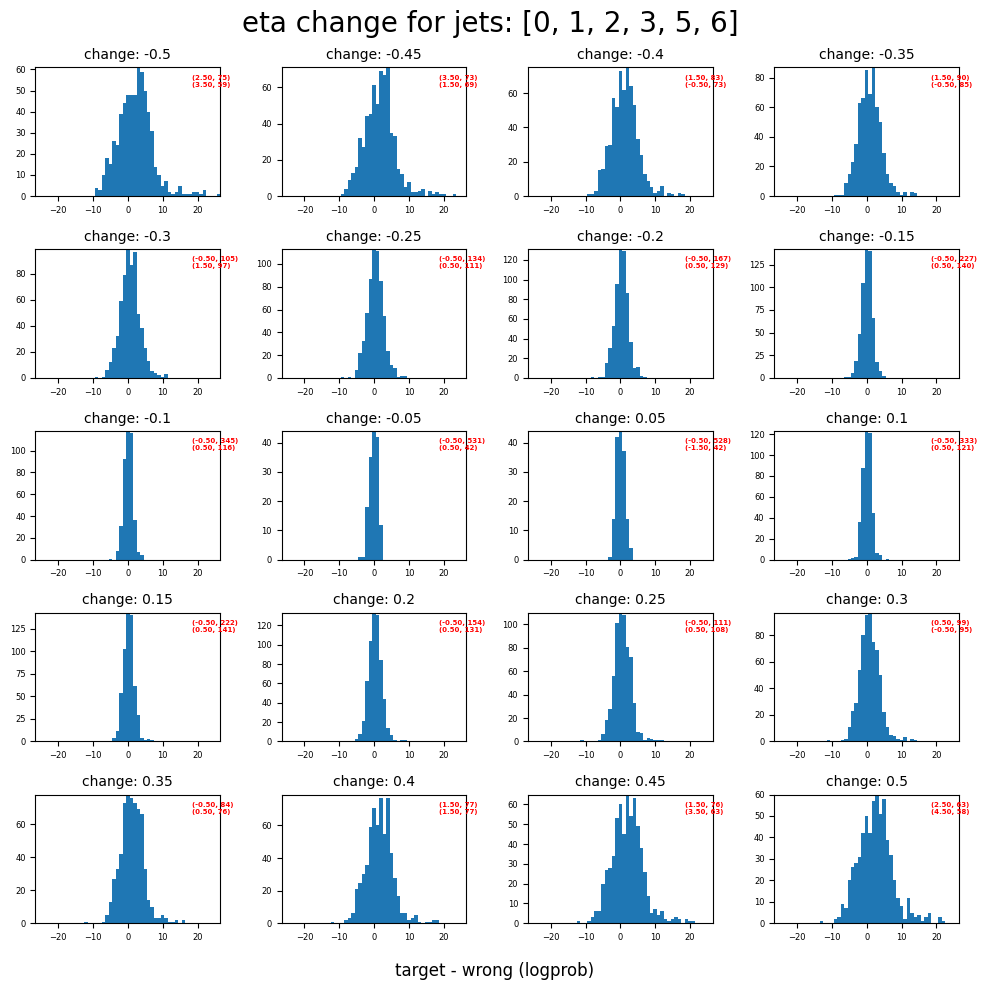

In [23]:
maxim = int(torch.max(torch.abs(diff_logprob_jets_eta).flatten()).item()) + 0.5
print(maxim)

plot_per_change(diff_logprob_jets_eta.numpy(), eta_change, modify_jets.tolist(), title_var='eta',
               range_x=(-1*maxim,maxim), peaks_to_clip=1, no_rows=5)

# 3rd: modify phi of jets

In [24]:
phi_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
diff_logprob_jets_phi = torch.zeros((len(phi_change), No_batches, batchSize))

for index, difference_phi in enumerate(phi_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
        
        wrong_logScaled_reco = alter_variables_tensor(difference=difference_phi,
                                                object_no=modify_jets,
                                                variable_altered=[2],
                                                target_var=scaledLogRecoParticles, 
                                                log_mean=log_mean_reco, 
                                                log_std=log_std_reco,
                                                mask_target=maskedReco,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        wrong_avg_flow_prob_pt, wrong_flow_prob_pt_batch, wrong_flow_prob_pt, \
        wrong_avg_flow_prob_eta, wrong_flow_prob_eta_batch, wrong_flow_prob_eta, \
        wrong_avg_flow_prob_phi, wrong_flow_prob_phi_batch, wrong_flow_prob_phi = transfer_flow(wrong_logScaled_reco,
                                                                    logScaled_data_higgs_t_tbar_ISR,
                                                                    boostReco,
                                                                    maskedReco,
                                                                    mask_boost)
        
        wrong_batch_flow_pr = wrong_flow_prob_pt_batch + wrong_flow_prob_eta_batch + wrong_flow_prob_phi_batch

        diff_logprob_jets_phi[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

4.5


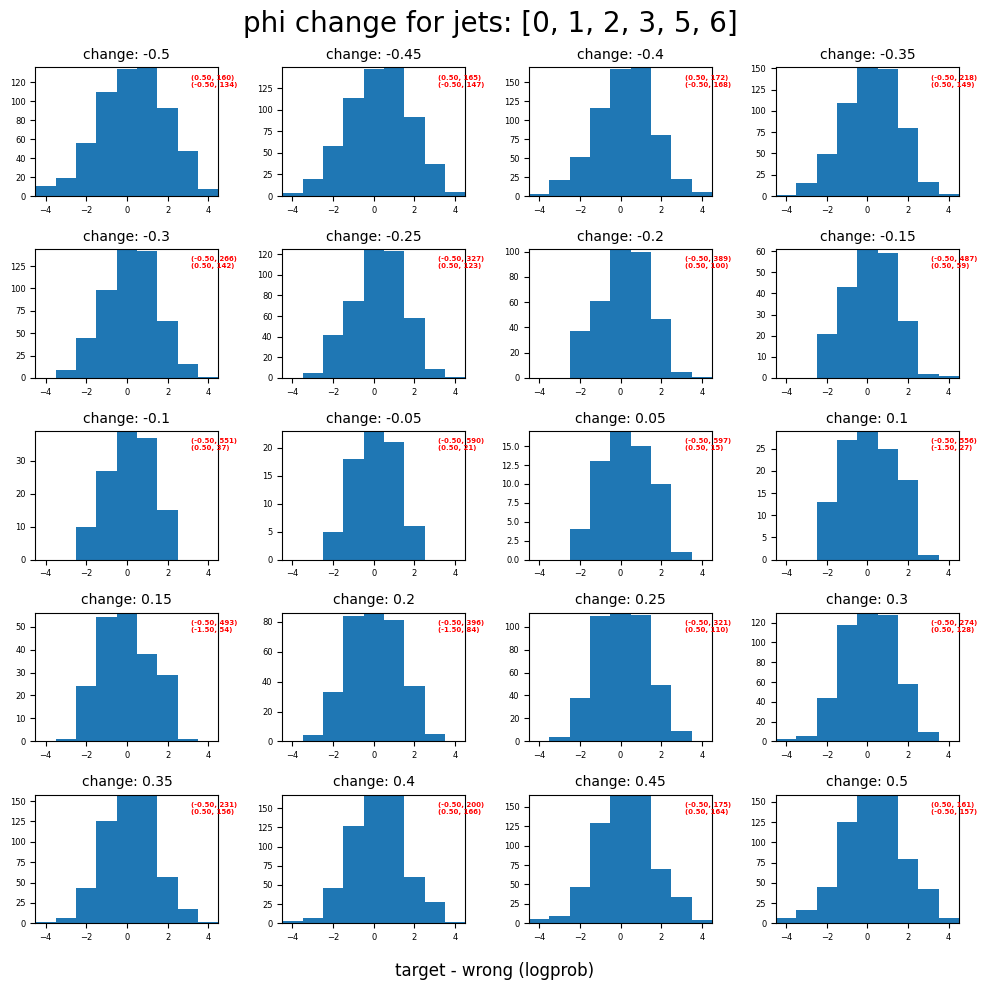

In [25]:
maxim = int(torch.max(torch.abs(diff_logprob_jets_phi).flatten()).item()) + 0.5
print(maxim)

plot_per_change(diff_logprob_jets_phi.numpy(), phi_change, modify_jets.tolist(), title_var='phi',
               range_x=(-1*maxim,maxim), peaks_to_clip=1, no_rows=5)

# II. Change partons

In [26]:
no_partons = torch.randint(1, 4, (1,))
print(no_partons)

perm = torch.randperm(4)
modify_partons = perm[:no_partons]
modify_partons, indices = torch.sort(modify_partons)
print(modify_partons.tolist())

mask_partons = torch.ones((batchSize, 4), device=device)

tensor([1])
[1]


# 1st. modify pt of partons

In [27]:
percentage_change = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10]
diff_logprob_partons_pt = torch.zeros((len(percentage_change), No_batches, batchSize))

transfer_flow.eval()
for index, percent in enumerate(percentage_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
    
        difference_pt = percent/100*data_higgs_t_tbar_ISR[:,modify_partons,0]
        
        wrong_logScaled_partons = alter_variables_tensor(difference=difference_pt,
                                                object_no=modify_partons,
                                                variable_altered=[0],
                                                target_var=logScaled_data_higgs_t_tbar_ISR[:,:,:3], 
                                                log_mean=log_mean_parton, 
                                                log_std=log_std_parton,
                                                mask_target=mask_partons,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        wrong_avg_flow_prob_pt, wrong_flow_prob_pt_batch, wrong_flow_prob_pt, \
        wrong_avg_flow_prob_eta, wrong_flow_prob_eta_batch, wrong_flow_prob_eta, \
        wrong_avg_flow_prob_phi, wrong_flow_prob_phi_batch, wrong_flow_prob_phi = transfer_flow(scaledLogRecoParticles,
                                                                wrong_logScaled_partons,
                                                                boostReco,
                                                                maskedReco,
                                                                mask_boost)
        
        wrong_batch_flow_pr = wrong_flow_prob_pt_batch + wrong_flow_prob_eta_batch + wrong_flow_prob_phi_batch

        diff_logprob_partons_pt[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

In [28]:
mask = torch.abs(diff_logprob_partons_pt) > 0.1
print(torch.count_nonzero(mask))

tensor(176)


2.5


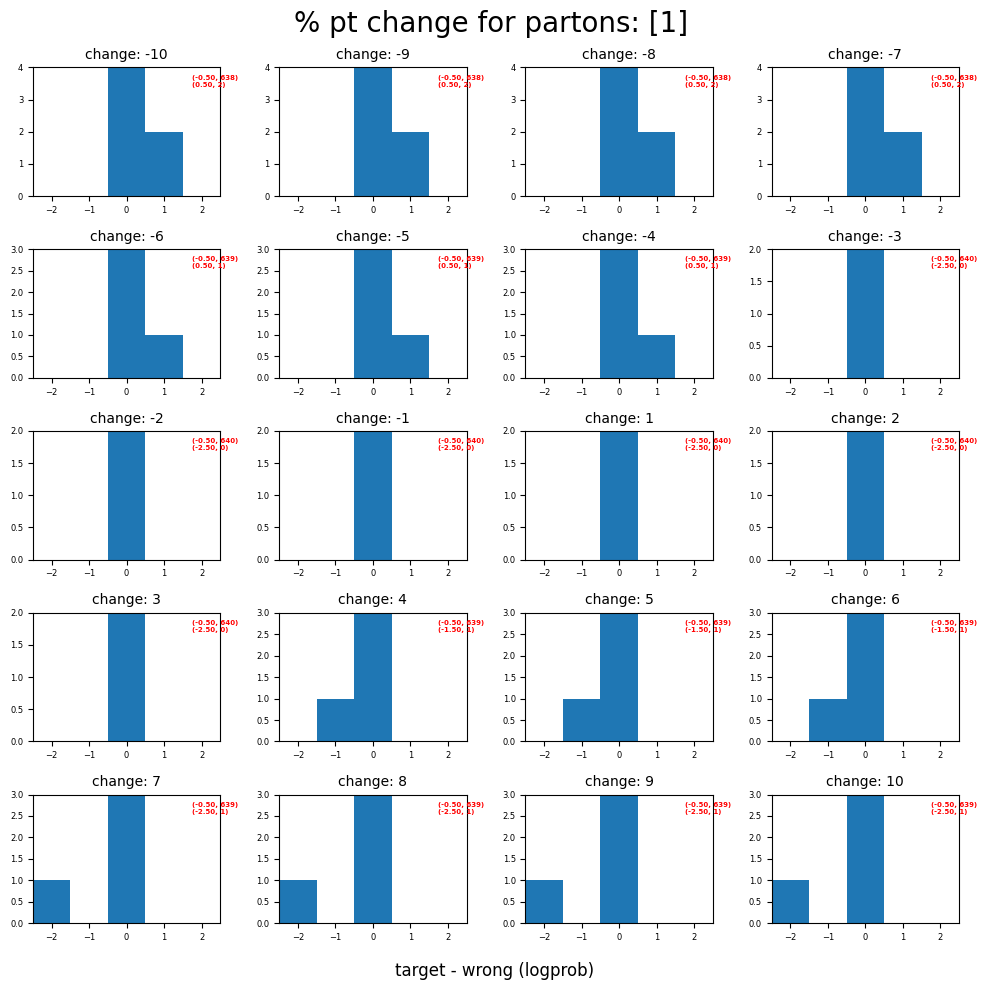

In [29]:
maxim = int(torch.max(torch.abs(diff_logprob_partons_pt).flatten()).item()) + 0.5
print(maxim)

plot_per_change(diff_logprob_partons_pt.numpy(), percentage_change, modify_partons.tolist(), title_var='% pt',
               range_x=(-1*maxim,maxim), peaks_to_clip=1, no_rows=5, particles_change='partons')

# 2nd: change eta of partons

In [30]:
eta_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
diff_logprob_partons_eta = torch.zeros((len(eta_change), No_batches, batchSize))

transfer_flow.eval()
for index, diff_eta in enumerate(eta_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
            
        wrong_logScaled_partons = alter_variables_tensor(difference=diff_eta,
                                                object_no=modify_partons,
                                                variable_altered=[1],
                                                target_var=logScaled_data_higgs_t_tbar_ISR[:,:,:3], 
                                                log_mean=log_mean_parton, 
                                                log_std=log_std_parton,
                                                mask_target=mask_partons,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        #print(wrong_logScaled_partons - logScaled_data_higgs_t_tbar_ISR)
        wrong_avg_flow_prob_pt, wrong_flow_prob_pt_batch, wrong_flow_prob_pt, \
        wrong_avg_flow_prob_eta, wrong_flow_prob_eta_batch, wrong_flow_prob_eta, \
        wrong_avg_flow_prob_phi, wrong_flow_prob_phi_batch, wrong_flow_prob_phi = transfer_flow(scaledLogRecoParticles,
                                                                wrong_logScaled_partons,
                                                                boostReco,
                                                                maskedReco,
                                                                mask_boost)
        
        wrong_batch_flow_pr = wrong_flow_prob_pt_batch + wrong_flow_prob_eta_batch + wrong_flow_prob_phi_batch

        diff_logprob_partons_eta[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    
        

13.5


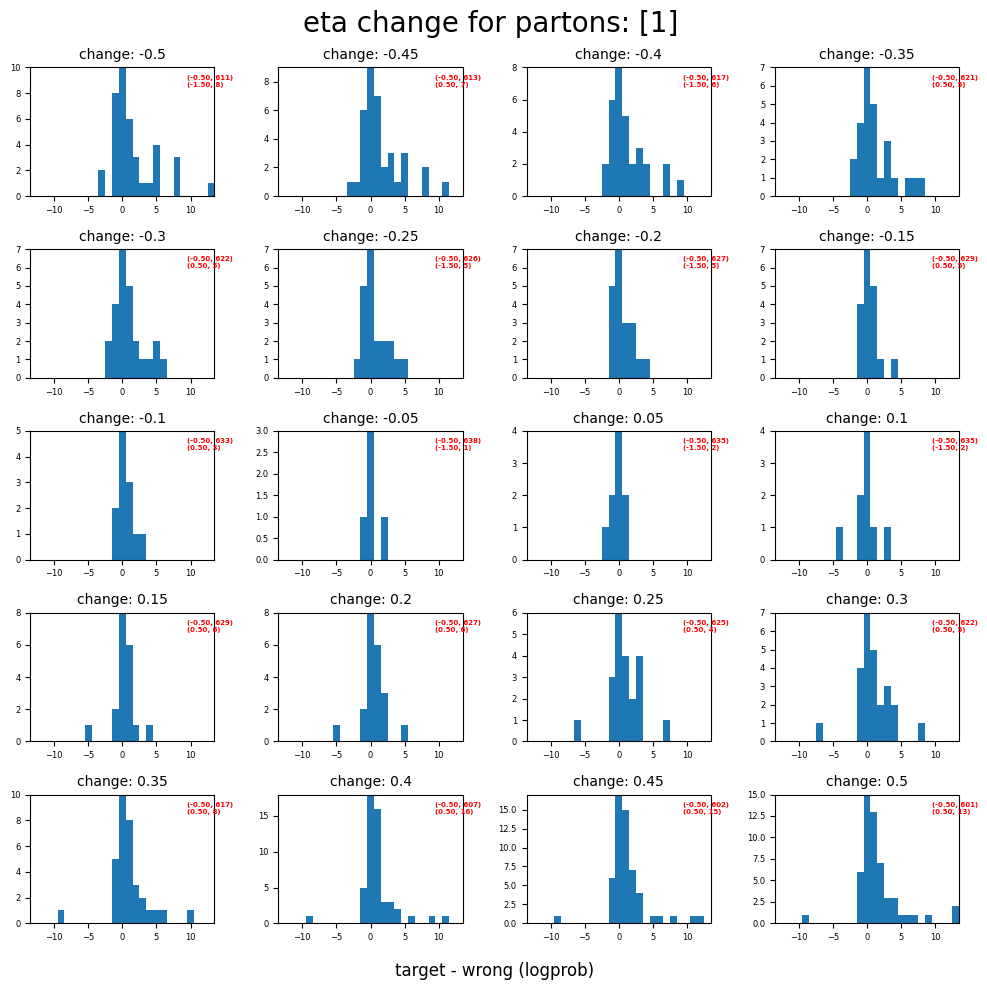

In [31]:
maxim = int(torch.max(torch.abs(diff_logprob_partons_eta).flatten()).item()) + 0.5
print(maxim)

plot_per_change(diff_logprob_partons_eta.numpy(), eta_change, modify_partons.tolist(), title_var='eta',
               range_x=(-1*maxim,maxim), peaks_to_clip=1, no_rows=5, particles_change='partons')

# 3rd: change phi of partons

In [32]:
phi_change = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05,
                    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
diff_logprob_partons_phi = torch.zeros((len(phi_change), No_batches, batchSize))

transfer_flow.eval()
for index, diff_phi in enumerate(phi_change):
    
    iterator = iter(testLoader)
    for idx in range(No_batches):
        
        data_batch = next(iterator)

        (data_higgs_t_tbar_ISR, logScaled_data_higgs_t_tbar_ISR,
        recoParticles, scaledLogRecoParticles, mask_lepton, 
        mask_jets, mask_met, mask_boost, boostReco) = data_batch

        maskedReco = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

        scaledLogRecoParticles = scaledLogRecoParticles[:,:,:7]
            
        wrong_logScaled_partons = alter_variables_tensor(difference=diff_phi,
                                                object_no=modify_partons,
                                                variable_altered=[2],
                                                target_var=logScaled_data_higgs_t_tbar_ISR[:,:,:3], 
                                                log_mean=log_mean_parton, 
                                                log_std=log_std_parton,
                                                mask_target=mask_partons,
                                                no_max_objects=config.transferFlow.no_max_objects, 
                                                device=device)

        wrong_avg_flow_prob_pt, wrong_flow_prob_pt_batch, wrong_flow_prob_pt, \
        wrong_avg_flow_prob_eta, wrong_flow_prob_eta_batch, wrong_flow_prob_eta, \
        wrong_avg_flow_prob_phi, wrong_flow_prob_phi_batch, wrong_flow_prob_phi = transfer_flow(scaledLogRecoParticles,
                                                                wrong_logScaled_partons,
                                                                boostReco,
                                                                maskedReco,
                                                                mask_boost)
        
        wrong_batch_flow_pr = wrong_flow_prob_pt_batch + wrong_flow_prob_eta_batch + wrong_flow_prob_phi_batch

        diff_logprob_partons_phi[index, idx] = target_events_logprob[idx] - wrong_batch_flow_pr.detach().cpu()
    

1.5


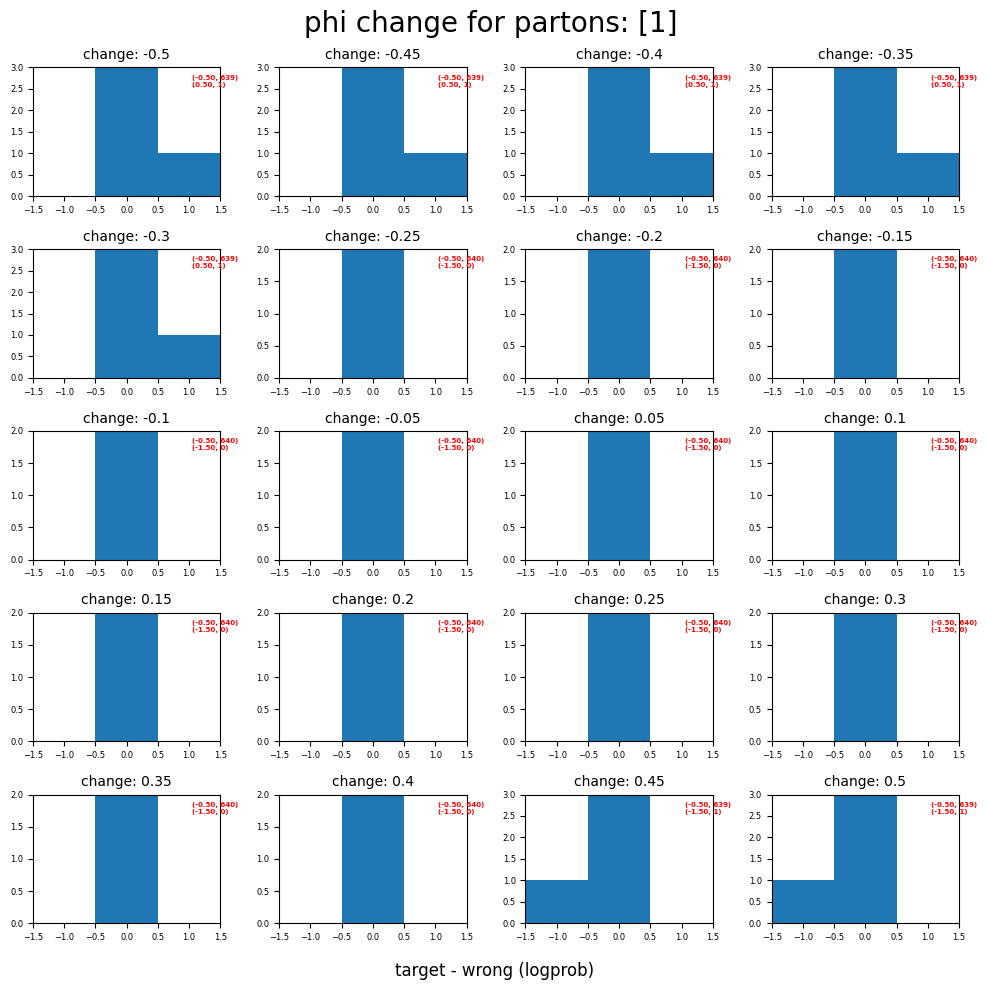

In [33]:
maxim = int(torch.max(torch.abs(diff_logprob_partons_phi).flatten()).item()) + 0.5
print(maxim)

plot_per_change(diff_logprob_partons_phi.numpy(), phi_change, modify_partons.tolist(), title_var='phi',
               range_x=(-1*maxim,maxim), peaks_to_clip=1, no_rows=5, particles_change='partons')

# check single event

In [18]:
check_ev = 10

event_parton = logScaled_data_higgs_t_tbar_ISR[check_ev].unsqueeze(dim=0)
event_reco = scaledLogRecoParticles[check_ev,:,:7].unsqueeze(dim=0)
event_boost = boostReco[check_ev].unsqueeze(dim=0)
maskBoost = mask_boost[check_ev].unsqueeze(dim=0)
maskReco = torch.cat((mask_jets[check_ev], mask_lepton[check_ev], mask_met[check_ev]), dim=0).unsqueeze(dim=0)

event_parton_distorded = event_parton + torch.rand(event_parton.shape, device=device)

print(event_parton)
print(event_parton_distorded)

target_avg_flow_prob_pt, target_flow_prob_pt_batch, target_flow_prob_pt, \
target_avg_flow_prob_eta, target_flow_prob_eta_batch, target_flow_prob_eta, \
target_avg_flow_prob_phi, target_flow_prob_phi_batch, target_flow_prob_phi = transfer_flow(event_reco,
                                                                event_parton,
                                                                event_boost,
                                                                maskReco,
                                                                maskBoost)

wrong_avg_flow_prob_pt, wrong_flow_prob_pt_batch, wrong_flow_prob_pt, \
wrong_avg_flow_prob_eta, wrong_flow_prob_eta_batch, wrong_flow_prob_eta, \
wrong_avg_flow_prob_phi, wrong_flow_prob_phi_batch, wrong_flow_prob_phi = transfer_flow(event_reco,
                                                                event_parton_distorded,
                                                                event_boost,
                                                                maskReco,
                                                                maskBoost)

target_batch_flow_pr = target_flow_prob_pt_batch + target_flow_prob_eta_batch + target_flow_prob_phi_batch
wrong_batch_flow_pr = wrong_flow_prob_pt_batch + wrong_flow_prob_eta_batch + wrong_flow_prob_phi_batch

print(target_batch_flow_pr)
print(wrong_batch_flow_pr)

tensor([[[-0.3303,  0.7380, -0.3308],
         [ 0.4421,  0.3984, -0.8708],
         [ 0.6861, -0.9485,  1.2394],
         [-0.3231, -0.2675,  0.3606]]], device='cuda:0')
tensor([[[-0.2047,  0.8189,  0.4831],
         [ 1.1320,  1.2853,  0.0925],
         [ 1.2221, -0.8469,  1.7252],
         [-0.1795, -0.0869,  1.0807]]], device='cuda:0')
tensor([7.1099], device='cuda:0', grad_fn=<AddBackward0>)
tensor([7.1099], device='cuda:0', grad_fn=<AddBackward0>)


tensor([[[-0.3303,  0.7380, -0.3308],
         [ 0.4421,  0.3984, -0.8708],
         [ 0.6861, -0.9485,  1.2394],
         [-0.3231, -0.2675,  0.3606]]], device='cuda:0')
tensor([[[-0.2047,  0.8189,  0.4831],
         [ 1.1320,  1.2853,  0.0925],
         [ 1.2221, -0.8469,  1.7252],
         [-0.1795, -0.0869,  1.0807]]], device='cuda:0')
torch.Size([1, 4, 128])


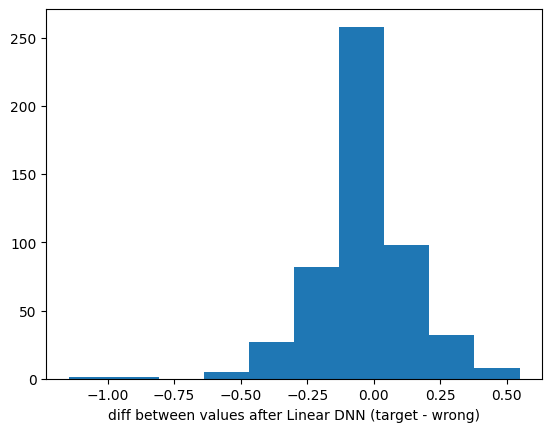

In [19]:
print(event_parton)
#print(event_reco)
print(event_parton_distorded)

scaledLogReco_afterLin = transfer_flow.gelu(transfer_flow.linearDNN_reco(event_reco) * maskReco[..., None])

scaledLogParton_afterLin_correct = transfer_flow.gelu(transfer_flow.linearDNN_parton(event_parton))
scaledLogParton_afterLin_wrong = transfer_flow.gelu(transfer_flow.linearDNN_parton(event_parton_distorded))

print(scaledLogParton_afterLin_correct.shape)
plt.hist((scaledLogParton_afterLin_correct - scaledLogParton_afterLin_wrong).flatten().detach().cpu().numpy())
plt.xlabel('diff between values after Linear DNN (target - wrong)')
plt.show()

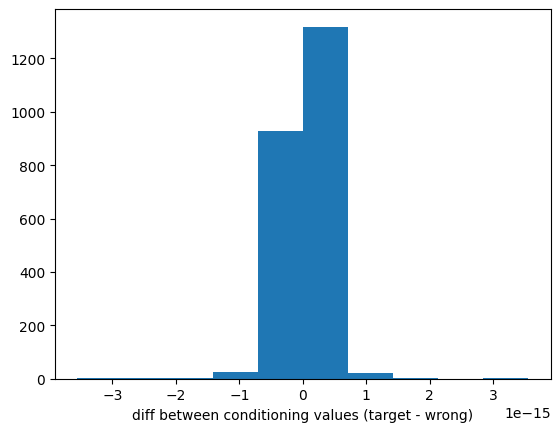

In [20]:
tgt_mask = transfer_flow.transformer_model.generate_square_subsequent_mask(18, device=device)

conditioning_correct = transfer_flow.transformer_model(scaledLogParton_afterLin_correct, scaledLogReco_afterLin,
                                                tgt_mask=tgt_mask)
conditioning_wrong = transfer_flow.transformer_model(scaledLogParton_afterLin_wrong, scaledLogReco_afterLin,
                                                tgt_mask=tgt_mask)

plt.hist((conditioning_correct - conditioning_wrong).flatten().detach().cpu().numpy())
plt.xlabel('diff between conditioning values (target - wrong)')
plt.show()

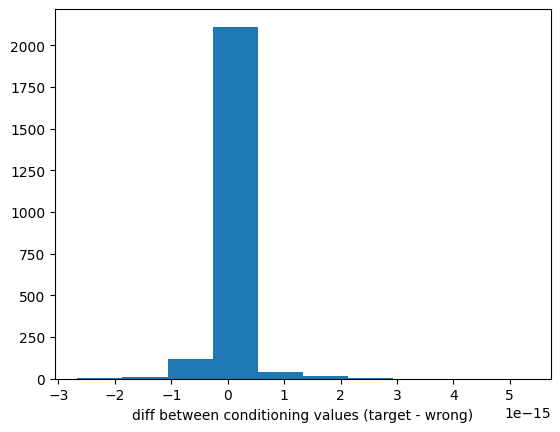

In [21]:
new_parton = scaledLogParton_afterLin_wrong + 2
conditioning_new = transfer_flow.transformer_model(new_parton, scaledLogReco_afterLin,
                                                tgt_mask=tgt_mask)
plt.hist((conditioning_correct - conditioning_new).flatten().detach().cpu().numpy())
plt.xlabel('diff between conditioning values (target - wrong)')
plt.show()

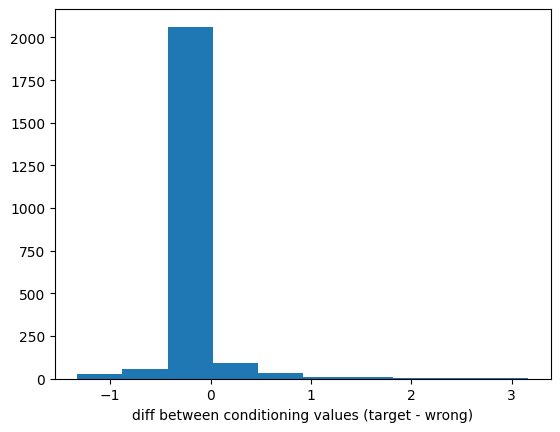

In [22]:
new_reco = scaledLogReco_afterLin + 0.1
conditioning_new = transfer_flow.transformer_model(scaledLogParton_afterLin_correct, new_reco,
                                                tgt_mask=tgt_mask)
plt.hist((conditioning_correct - conditioning_new).flatten().detach().cpu().numpy())
plt.xlabel('diff between conditioning values (target - wrong)')
plt.show()

# Check samples of Unfolding FLow